## A Rough Skeleton of Working Draft
---------------------------------------------------------------------------------------------------------


### Table of Contents:
1. Sypnosis
<br>
    a) Research Question
    <br>
    b) Overview
<p></p>
2. Selection of Data 
<br>
    a) Packages Used
    <br>
    b) Loading and Tidying Data
<p></p>
3. Training, Validation, and Testing Sets
<br>
    a) Compartmentalization
    <br>
    b) Training Data Summaries
<p></p>
4. Preprocessing 
<br>
    a) Preliminary Data Analysis
    <br>
    b) Indetification of Class Imbalances
    <br>
    c) Balancing Decision
<p></p>
5. Building our Model
<br>
    a) Overview 
    <br>
    b) Tuning
    <br>
    c) Accuracy Comparison
<p></p>
6. Analysis
<br>
    a) Classifying a New Observation
<p></p>
7. Results and Discussion
<br>
    a) Results
    <br>
    b) Discussion

---

### 1. Sypnosis

##### a) Research Question:
How can an author increase engagement from users on Facebook and can we predict the success of a post using insights from an author's page?


##### b) Overview:
The market utility of social media platforms such as Facebook, which are able to generate mass revenues for cosmetic brands, has been an established and exploited advertising strategy in the digital age (Moro et. al, 2016).
The goal of this project is to take a predictive analytical approach to determine which type of Facebook post (i.e., photo, video, status, or link) will engage the most internet-user engagement, determined through variables such as likes, post consumptions, and post total reach.
The dataset which will be used for this analysis was acquired through an experimental data mining technique which included scraping data from the Facebook page of an internationally renowned cosmetics company on posts made between January 1st and December 31st (Moro et. al., 2016).

We will use the variables of the continuous numerical variables of total reaches (Lifetime_Post_Total_Reach) and the number of total interactions (Total_Interactions), and the categorical variable of Facebook post (Type). We chose the two continuous numerical variables of total reach and total interactions as predictors because they are key indicators of success that are interrelated. Although we do not consider factors such as the type of users (influencers, company profiles, regular users,etc.), the variable of total reach must be put in relations with total interactions to offer a valuable insight. That is because total interactions influence Facebook's algorithm that may result in a viral post and thus increase the total reach regardless of the extent of the user's total network (number of friends, affiliated groups,etc.)(Quesenberry & Coolsen, 2018). Therefore, the variables of total reach and total interactions must be paired to fully graps the success of a post as both can create a postivie feedback loop. 

For the methodology, we will look at the relationship between these variables in a scatter plot graph that will help us to formulate our hypothesis. Then, as we are trying to predict the type of post that will be the most successful, we will use a K-nearest neighbour classification analysis. To do so, we must determine the K value using cross-validation of the training data.Then, we will need to test the accuracy of the classifier with the testing data.

We expect to find that posts which include media, such as photos and videos, are more likely to engage users than other posts, such as statuses and links.This is based on the assumption that the former types of posts might be more likely to be shared and thus will have more exposure.It is beneficial for social media platforms to increase user engagement, as this is likely to increase revenue through advertising.Therefore, these findings may be used to choose what type of posts are prioritized to maximize user engagement.

These findings may lead to further exploration of how the contents of these posts impact user engagement.
This may include the duration of a video, content of an image, length of a status, or details about the contents of a link. 

---

### 2. Selection of data

##### Global options

Here, we set some global parameters in order to reduce cluttering of output information as well as the visibility of warning messages. The latter is enforced later in the code with suppressMessages().

In [1]:
options(repr.matrix.max.rows = 8)
options(warn = -1)

#### a) List of Packages Used

In [2]:
suppressMessages(install.packages("cowplot"))
suppressMessages(install.packages("caTools"))

suppressMessages(library(caTools))
suppressMessages(library(tidyverse))
suppressMessages(library(repr))
suppressMessages(library(tidymodels))
suppressMessages(library(kknn))
suppressMessages(library(MASS))
suppressMessages(library(cowplot))
suppressMessages(library(ggplot2))

#### b) Loading and Tidying Data
First, we read in our data from a remote github repository. We ensured that all variables were converted to factors (i.e., categorical variables) since this data type agrees well with knn classification algorithms. Further, since certain functions do not permit manipuation of columns which have a space in their name, we removed all spaces from column names.  

In [3]:
facebook_url <-
    "https://raw.githubusercontent.com/calamari99/Facebook-Post-Predictor/main/data/dataset_Facebook.csv"

facebook <- read_csv2(facebook_url) %>%
    suppressMessages()

# Replacing specified columns to categorical factors
cols <- c("Type", "Category", "Post Month", "Paid", "Post Weekday", "Post Hour")
facebook[cols] <- lapply(facebook[cols], as.factor)

# Renaming column headers in order to remove spaces
facebook_colname_fix <- facebook

facebook_col_name_vec <- gsub(" ", "_", colnames(facebook))
colnames(facebook) <- facebook_col_name_vec

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



##### Let us select only the variables relevant to our analysis.

To specify the best type of post possible and to explore the relationship between the metrics produced by a post and the post type.
We determined that the following key performance indicators best describe a post's success:
- comments
- likes
- shares
- total interactions (summation of the 3 observations above) 

In [4]:
# Select variables relevant to our analysis
facebook_clean <- dplyr::select(facebook, Type, comment,
                                like, share, Total_Interactions,
                                Paid, Lifetime_Post_Total_Impressions,
                                Lifetime_Post_Total_Reach) %>%
                            na.omit(df)

# Separate paid and unpaid posts
facebook_clean_unpaid <- facebook_clean %>% filter(Paid == 0)
facebook_clean_paid <- facebook_clean %>% filter(Paid == 1)

# Summary of unpaid posts by type
unpaid_summary <- facebook_clean_unpaid %>% group_by(Type) %>% 
    summarise(unpaid = n()) 

# Summary of paid posts by type
paid_summary <- facebook_clean_paid %>% group_by(Type) %>% 
    summarise(paid = n())

Reduce(dplyr::full_join, list(unpaid_summary, paid_summary)) %>%
    suppressMessages()

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "Type"



Type,unpaid,paid
<fct>,<int>,<int>
Link,16,6
Photo,302,119
Status,35,10
Video,3,4


Within our 500 data points collected, we have filtered out all observations with NA values and separated our data into paid and unpaid categories due to additive relationships.
This allows us to explore the relationship between post type and our defined success metric.
Moving forward, this study will only evaluate on media postings without paid advertising.

> Note: Social media algorithms that adjust prioritizations between paid and non-paid posts can heavily factor into our metrics received and should be considered in this analysis. To control for this potential source of uncertainty, we haved isolated our data into paid and unpaid categories. 

---

### 3. Training, Validation, and Testing Sets 



#### a) Compartmentalization
We have split our data into training and testing sets in order to reduce bias within our model data and testing data. 

*Distribution of Training and Testing set*
<br>
- Testing set will be 20% of data collected
<br>
- Validation set will be 10% of data collected
<br>
- Training data set be 70% of data collected

*Cross-validation technique*
<br>
let us split our data into 10 total groups.
<br>
(~25 points tested, 100 points for training)

We chose to approach our training data by creating a 80:20 ratio between testing and training data where the  training set is composed of both the “validation” and “training” set.
We have also chosen a 10-fold cross-validation procedure to establish unbiased estimators.

In [5]:
# Defining Variables
set.seed(99)
partitionTrain = 0.8
ratioTrainValidation = 7/8

##### Total Posts:

In [6]:
# 80/20 ratio TrainingSet:TestingSet
split <- sample.split(facebook_clean$like, SplitRatio = partitionTrain)
train_val_data <- subset(facebook_clean, split == TRUE)
test_set <- subset(facebook_clean, split == FALSE)

split <- sample.split(train_val_data$like, SplitRatio = ratioTrainValidation)
train_set <- subset(train_val_data, split == TRUE)
val_set <- subset(train_val_data, split == FALSE)

train_set

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Photo,4,79,17,100,0,5091,2752
Photo,19,325,49,393,0,13594,7244
Photo,3,249,27,279,1,19479,11692
Photo,0,325,14,339,1,24137,13720
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,10,125,41,176,0,9218,5400
Photo,5,53,26,84,0,7536,4684
Photo,0,53,22,75,0,6229,3480
Photo,4,93,18,115,0,7216,3778


#### Unpaid Posts:

In [7]:
split <- sample.split(facebook_clean_unpaid$like, SplitRatio = partitionTrain)
train_val_data_unpaid <- subset(facebook_clean_unpaid, split == TRUE)
test_set_unpaid <- subset(facebook_clean_unpaid, split == FALSE)

split <- sample.split(train_val_data_unpaid$like, SplitRatio = ratioTrainValidation)
train_set_unpaid <- subset(train_val_data_unpaid, split == TRUE)
val_set_unpaid <- subset(train_val_data_unpaid, split == FALSE)

#glimpse(train_set_unpaid)
train_set_unpaid

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Status,5,130,29,164,0,19057,10460
Photo,19,325,49,393,0,13594,7244
Status,1,152,33,186,0,20849,10472
Status,0,161,31,192,0,22538,11844
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,17,185,55,257,0,13960,8412
Photo,10,125,41,176,0,9218,5400
Photo,5,53,26,84,0,7536,4684
Photo,4,93,18,115,0,7216,3778



#### b) Training Data Summaries

- Number of observations of each type
- Mean and Median of key metrics in each post type


##### Summary of Unpaid Posts:

In [8]:
summ_train_unpaid <- train_set_unpaid %>%
    group_by(Type) %>%
        summarise(
        count = n(),
        mean_comment = mean(comment), 
        median_comment = median(comment), 
        mean_like = mean(like),
        median_like = median(like),
        mean_Total_Interactions = mean(Total_Interactions),
        median_Total_Interactions = median(Total_Interactions),
        mean_share = mean(share),
        median_share = median(share))

summ_train_unpaid

`summarise()` ungrouping output (override with `.groups` argument)



Type,count,mean_comment,median_comment,mean_like,median_like,mean_Total_Interactions,median_Total_Interactions,mean_share,median_share
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Link,10,3.100000,1,100.9000,73.5,119.8000,85,15.80000,11
Photo,210,6.404762,2,155.9905,93.0,186.5476,115,24.15238,18
Status,25,6.880000,3,145.8400,129.0,179.4800,164,26.76000,27
Video,3,10.333333,6,216.0000,204.0,285.6667,271,59.33333,44


---

### 4. Preprocessing 

#### a) Preliminary Data Analysis

To inform analysis later on, we first conducted a preliminary exploration of our dataset.
<p>
In order to gain more insight on the relationship between each type of post and the magnitude of its interactions, we started by taking the mean value of each interaction type with respect to each post type.

In [9]:
mean_comment <- summ_train_unpaid$mean_comment
mean_like <- summ_train_unpaid$mean_like
mean_Total_Interactions <- summ_train_unpaid$mean_Total_Interactions
mean_share <- summ_train_unpaid$mean_share
type <- summ_train_unpaid$Type

test_df <- data.frame(type,
                      mean_comment,
                      mean_like,
                      mean_share,
                      mean_Total_Interactions)

test_df

fb_long <- test_df %>%
gather("Stat", "Value", -type)

fb_long

type,mean_comment,mean_like,mean_share,mean_Total_Interactions
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Link,3.100000,100.9000,15.80000,119.8000
Photo,6.404762,155.9905,24.15238,186.5476
Status,6.880000,145.8400,26.76000,179.4800
Video,10.333333,216.0000,59.33333,285.6667


type,Stat,Value
<fct>,<chr>,<dbl>
Link,mean_comment,3.100000
Photo,mean_comment,6.404762
Status,mean_comment,6.880000
Video,mean_comment,10.333333
⋮,⋮,⋮
Link,mean_Total_Interactions,119.8000
Photo,mean_Total_Interactions,186.5476
Status,mean_Total_Interactions,179.4800
Video,mean_Total_Interactions,285.6667


To compare how many likes, each post receives, we can filter the above table to only show likes.

In [10]:
filter_mean_like <- fb_long %>%
    filter(Stat == "mean_like") %>%
    arrange(desc(Value))

filter_mean_like

type,Stat,Value
<fct>,<chr>,<dbl>
Video,mean_like,216.0000
Photo,mean_like,155.9905
Status,mean_like,145.8400
Link,mean_like,100.9000


We can see from the above table that videos tend to receive the most likes on average, while links tend to receive the fewest. We can compare these values by plotting them on a bar graph.

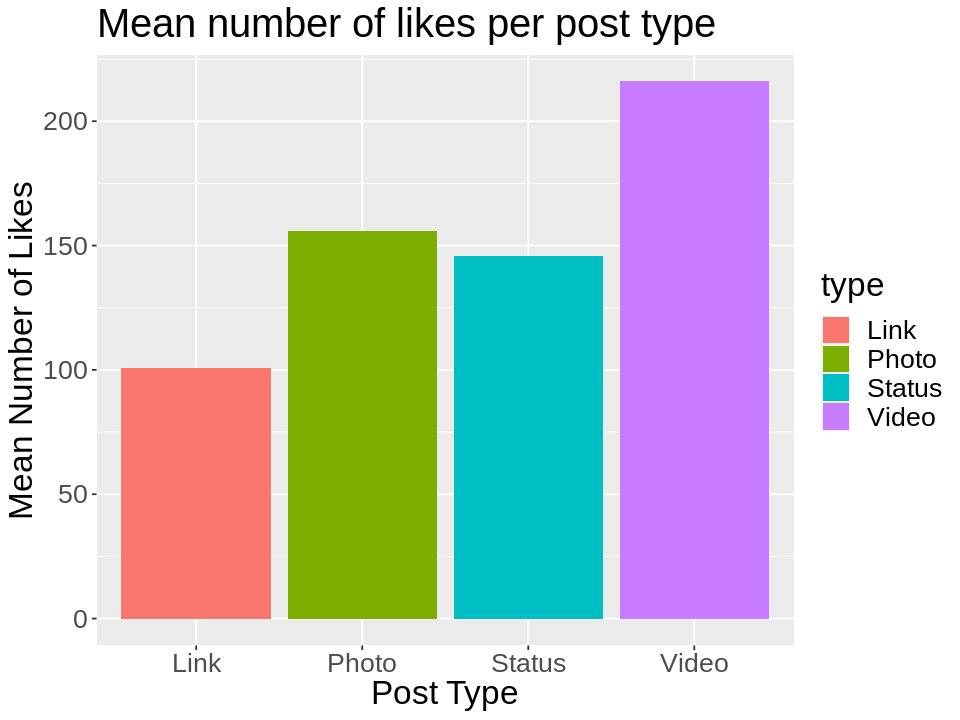

In [11]:
options(repr.plot.width = 8, repr.plot.height = 6) 

mean_likes_bar <- ggplot(filter_mean_like, aes(x = type, y = Value, fill = type)) +
    geom_bar(stat = "identity") +
    labs(x = "Post Type", y = "Mean Number of Likes",
         title = "Mean number of likes per post type") +
    theme(text = element_text(size = 20)) 
mean_likes_bar

We can see from the graph above that videos tend to receive significantly more likes than other post types. Additionally, photos and status posts receive similar number of likes compared to each other. Links receive significantly fewer likes than all other types of posts.
<p>
If we repeat this process without filtering for likes, we can compare the engagement per post across all types of engagement.

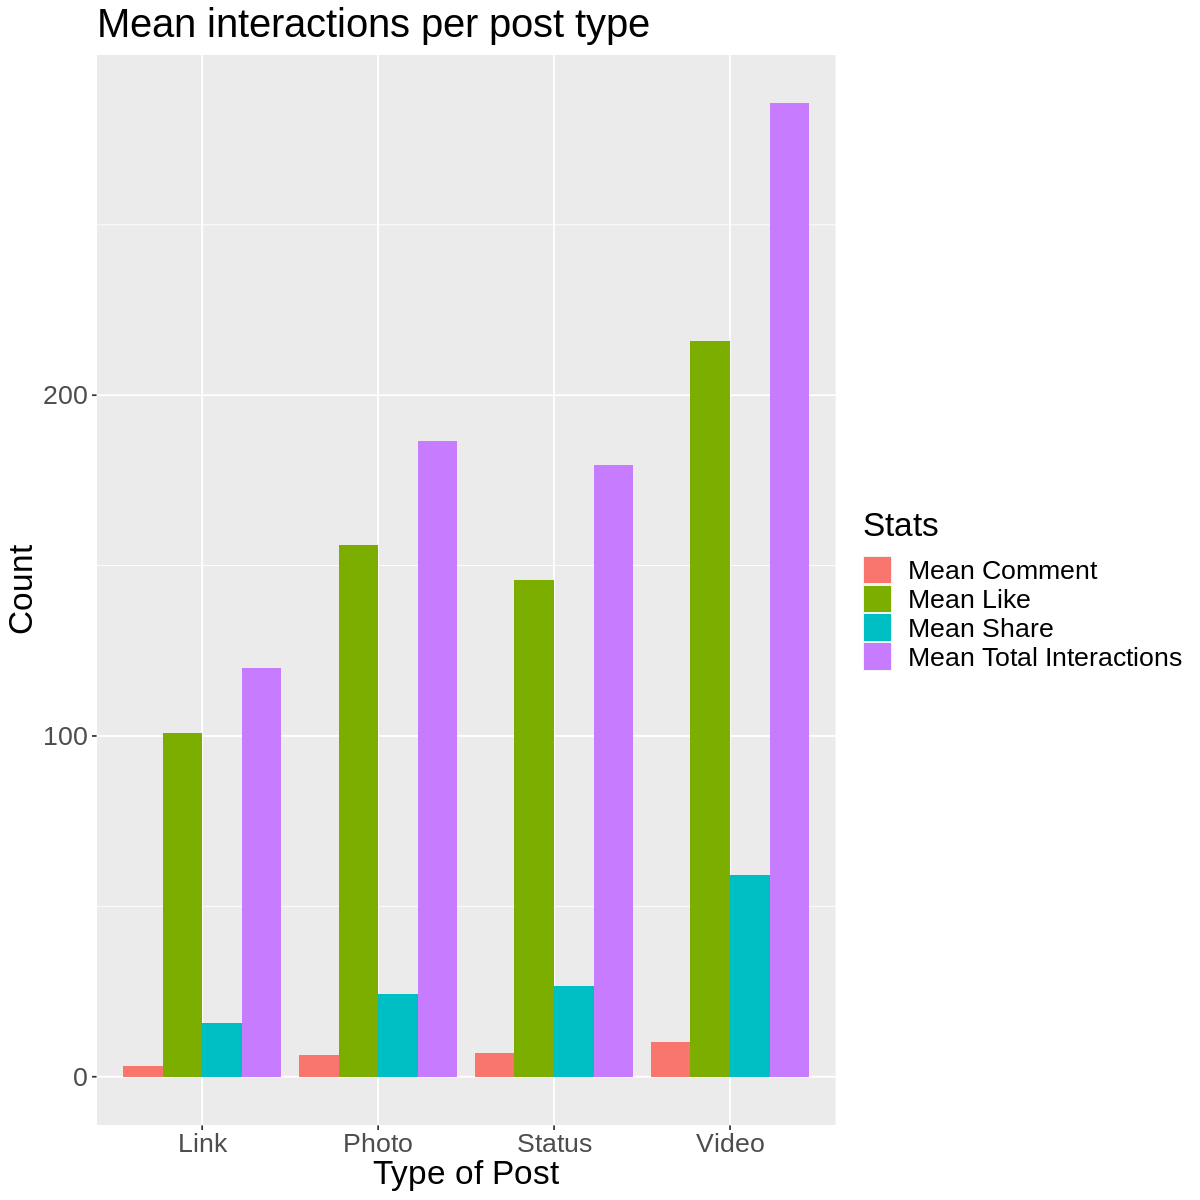

In [12]:
options(repr.plot.width=10, repr.plot.height=10)
mean_fb <- ggplot(fb_long, aes(x = type, y = Value, fill = Stat)) +
    geom_col(position = "dodge") +
    labs(x = "Type of Post", y = "Count", title="Mean interactions per post type") +
    scale_fill_discrete(name = "Stats",
                        labels = c("Mean Comment", "Mean Like", "Mean Share", "Mean Total Interactions"))+
    theme(text = element_text(size = 20))
mean_fb

From this graph, we can see that the ratio between the amounts of engagement for different types of post are roughtly equal regardless of the type of interaction. Additionally, all types of posts tend to receive very few comments and shares compared to the number of likes.

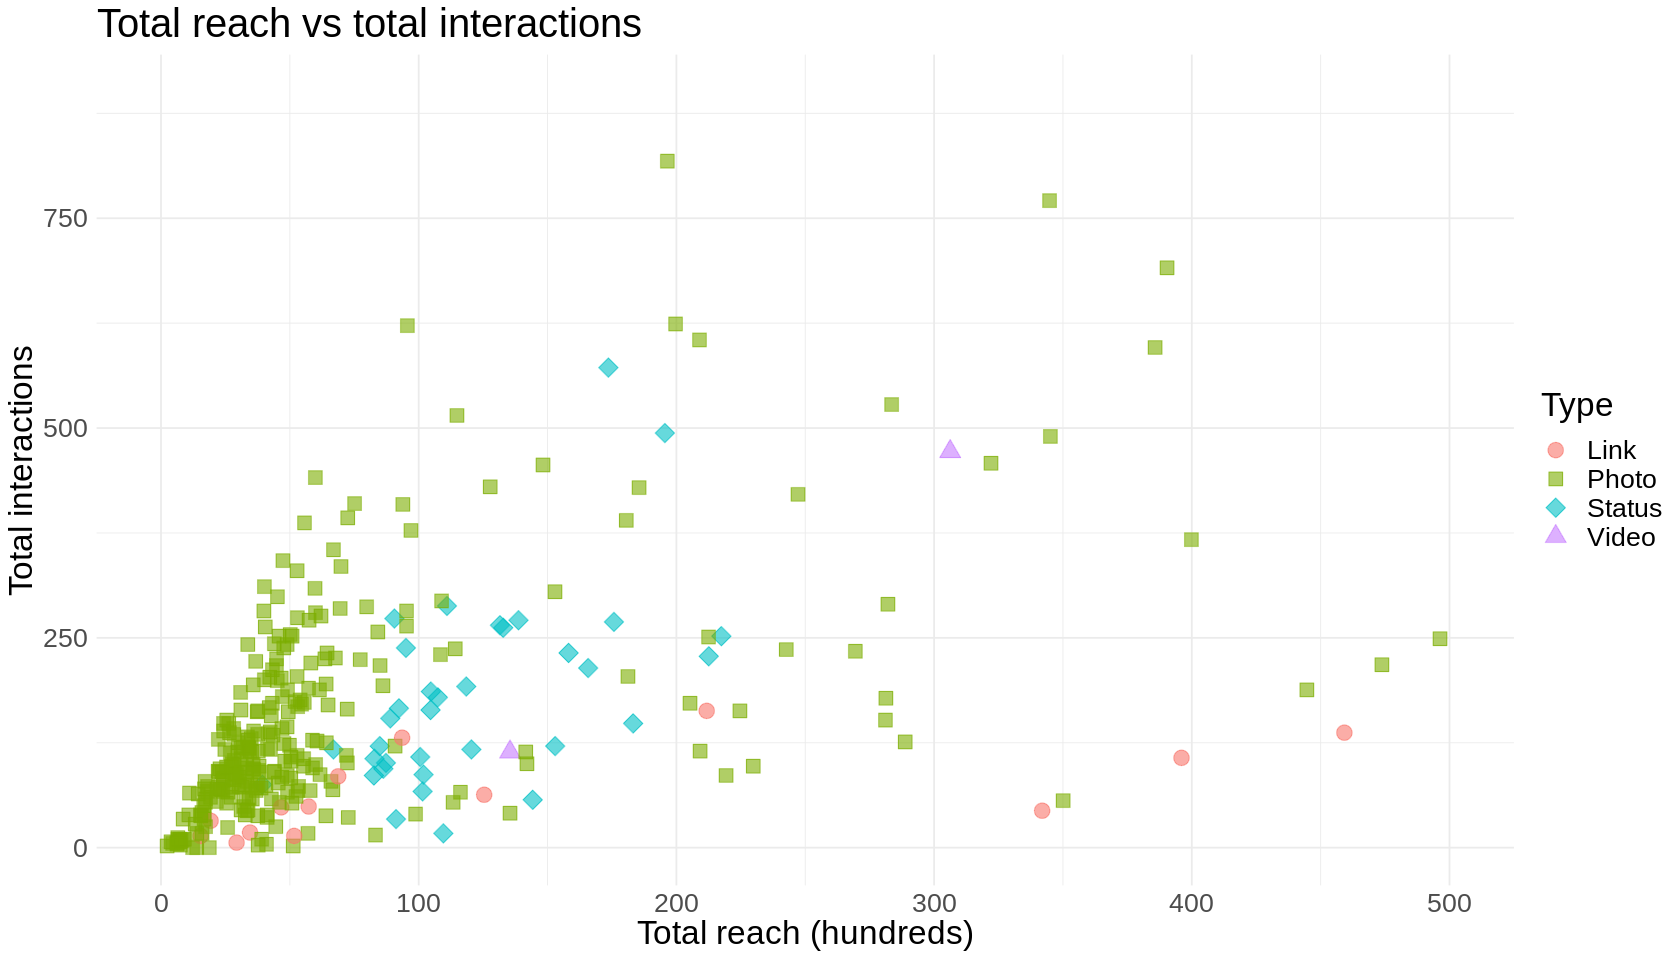

In [13]:
unpaid_plot <- facebook_clean_unpaid %>% 
    ggplot(aes(x = Lifetime_Post_Total_Reach/100,
               y = Total_Interactions,
               shape = Type,
               color = Type,
               fill = Type)) +
    geom_point(alpha=0.6, size=4) +
    labs(x = "Total reach (hundreds)", y = "Total interactions",
         title = "Total reach vs total interactions", group = "Type")+
    scale_y_continuous(limits = c(0,900)) +
    scale_x_continuous(limits = c(0,500)) +
    scale_shape_manual(values = c(21,22,23,24)) +
    scale_size_manual(values=c(1,6,7,9)) +
    theme_minimal() +
    theme(text = element_text(size = 20))
    options(repr.plot.width =14, repr.plot.height = 8)
unpaid_plot 

#### b) Identification of Class Imbalances
We want to be able to identify possible class imbalances as the KNN-classification model is a lazy learning algorithm.
Thus we need to ensure that our data set is balanced.
We start by reviewing summary statistics and quickly visualizing the distribution of observations.

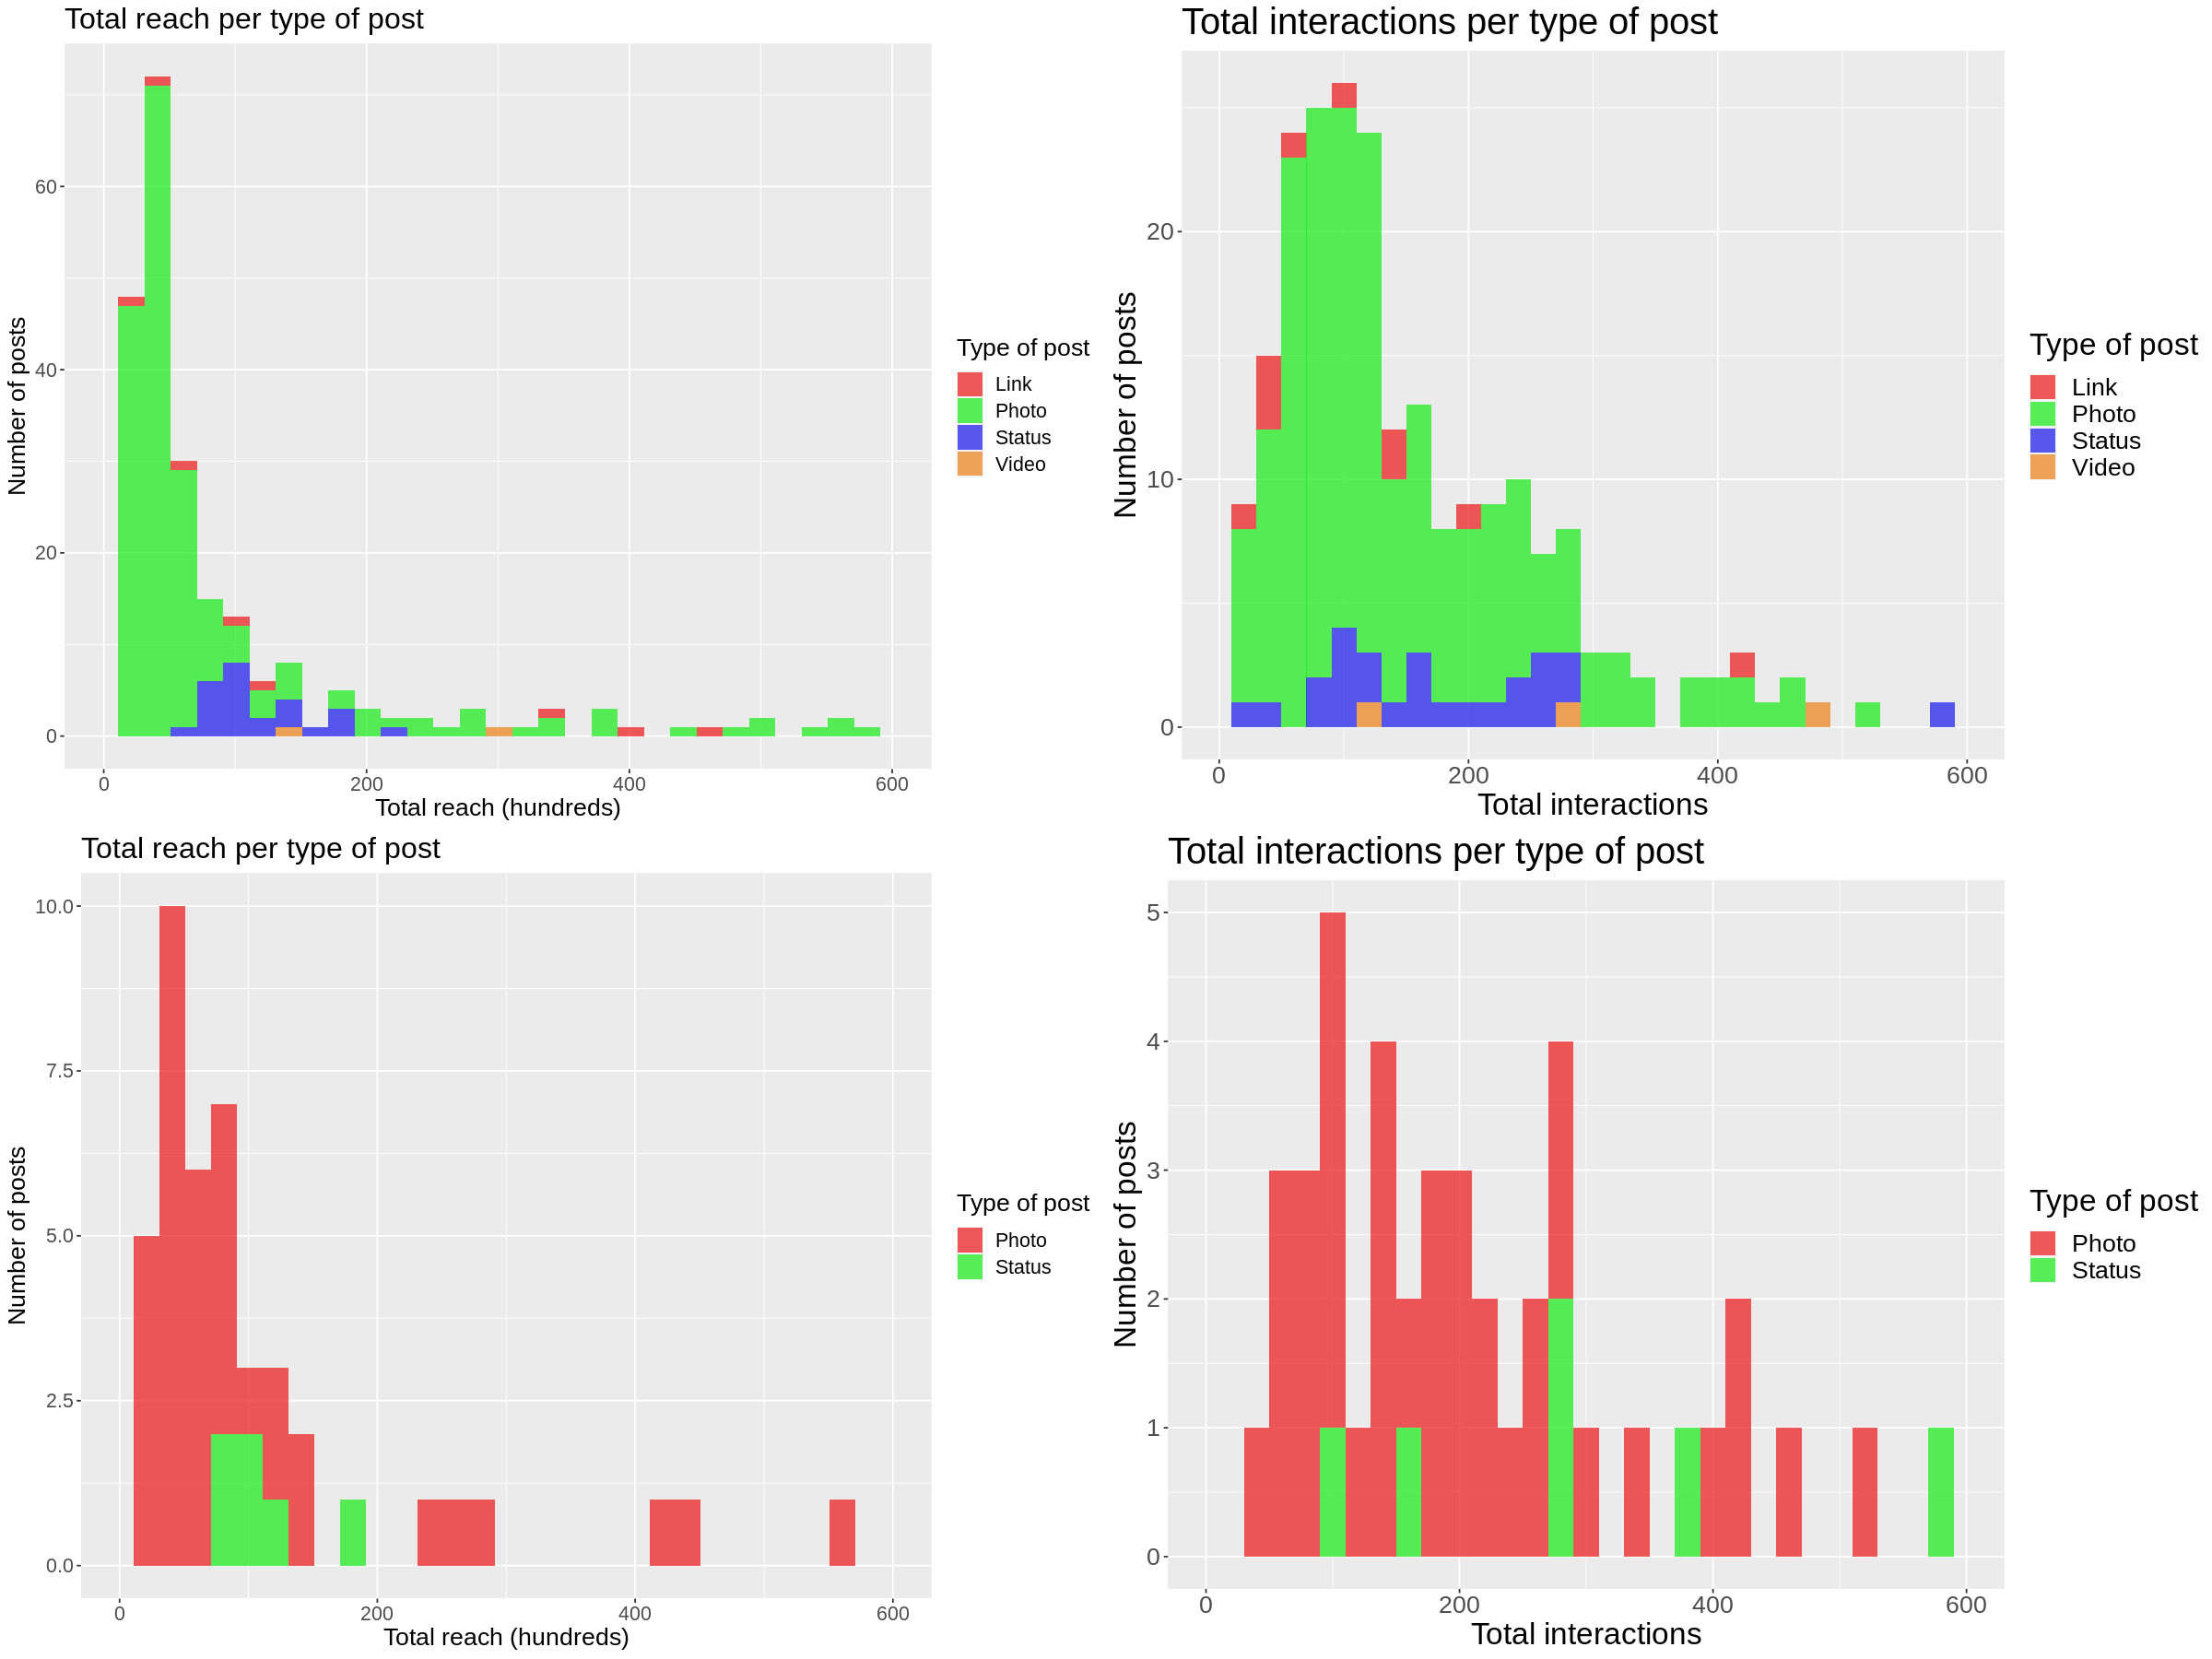

In [14]:
options(repr.plot.width=20, repr.plot.height=15)

test_unpaid_hist_1 <- train_set_unpaid %>%
    ggplot(aes(fill=Type, x=Lifetime_Post_Total_Reach/100))+
    geom_histogram(binwidth = 20,
                   center = 1,
                   boundary = NULL,
                   alpha = 0.7,
                   position = position_stack(vjust=0, reverse=FALSE))+
    labs(x="Total reach (hundreds)", y="Number of posts",
         title="Total reach per type of post", fill="Type of post")+
    scale_x_continuous(limits = c(0,600))+
    scale_fill_manual(values = c("#eb1515", "#15eb15", "#1515eb", "#eb8015"))+
    theme(text = element_text(size = 16))

test_unpaid_hist_2 <- train_set_unpaid %>%
    ggplot(aes(x=Total_Interactions, fill=Type))+
    geom_histogram(binwidth = 20,
                   alpha = 0.7,
                   position = position_stack(vjust=0, reverse=FALSE))+
    labs(x="Total interactions", y="Number of posts",
         title="Total interactions per type of post", fill="Type of post")+
    scale_fill_manual(values = c("#eb1515", "#15eb15", "#1515eb", "#eb8015"))+
    scale_x_continuous(limits = c(0,600))+
    theme(text = element_text(size = 20))

test_val_hist_1 <- val_set %>%
    ggplot(aes(fill=Type, x=Lifetime_Post_Total_Reach/100))+
    geom_histogram(binwidth = 20,
                   center = 1,
                   boundary = NULL,
                   alpha = 0.7,
                   position = position_stack(vjust=0, reverse=FALSE))+
    labs(x="Total reach (hundreds)", y="Number of posts",
         title="Total reach per type of post", fill="Type of post")+
    scale_x_continuous(limits = c(0,600))+
    scale_fill_manual(values = c("#eb1515", "#15eb15", "#1515eb", "#eb8015"))+
    theme(text = element_text(size = 16))

test_val_hist_2 <- val_set %>%
    ggplot(aes(x=Total_Interactions, fill=Type))+
    geom_histogram(binwidth = 20,
                   alpha = 0.7,
                   position = position_stack(vjust=0, reverse=FALSE))+
    labs(x="Total interactions", y="Number of posts",
         title="Total interactions per type of post", fill="Type of post")+
    scale_fill_manual(values = c("#eb1515", "#15eb15", "#1515eb", "#eb8015"))+
    scale_x_continuous(limits = c(0,600))+
    theme(text = element_text(size = 20))

plot_grid(test_unpaid_hist_1,test_unpaid_hist_2, test_val_hist_1, test_val_hist_2, ncol = 2) %>%
    suppressMessages()

#### Balancing Decision
We see the distribution of the type of posts is not equal so we should consider balancing.
However, this introduces potential complications in further parts of our analysis, mainly the cross validation step.
We find that balancing our data in this part of our analysis results in overestimated accuracies for our cross validation model later on.
Additionally, we are hestitant to balance training set because this alternation is not reflected in our testing set, which can lead to more uncertainty.
Because of these factors, we chose to leave our data unbalanced.
We believe this will lead to less biased results when using our training data set further in our report.

---

### 5. Building our Model

#### a) Overview
We use the original training data into our tuning selection process.
Then by scaling the data and following the tidymodel recipes workflow, we collect the results from various values of k.
Our base value of k is set to 3.

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
      set_engine("kknn") %>%
      set_mode("classification")

unpaid_recipe <- recipe(Type ~ 
                        Lifetime_Post_Total_Reach + Total_Interactions,
                        data = train_set_unpaid) %>%
                    step_scale(all_predictors()) %>%
                    step_center(all_predictors())

unpaid_fit <- workflow() %>%
    add_recipe(unpaid_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = train_set_unpaid)

unpaid_val_predicted <- predict(unpaid_fit, val_set_unpaid) %>%
    bind_cols(val_set_unpaid)

unpaid_prediction_accuracy <- unpaid_val_predicted %>%
    metrics(truth = Type, estimate = .pred_class)
    
unpaid_prediction_accuracy

unpaid_val_predicted %>%
    conf_mat(truth = Type, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8333333
kap,multiclass,0.4130435


          Truth
Prediction Link Photo Status Video
    Link      0     0      0     0
    Photo     0    27      1     0
    Status    0     5      3     0
    Video     0     0      0     0

Our pre-tuned model accuracy against our validation set was roughly 83%. The low accuracy is connected with the collection of observations within the validation data set itself. Our validation set which was sampled at random had only included observations from 2 types: Photo and Status. Upon running our model against this sample population, the collection of predictions included observations from the Link category as well thus creating inaccuracy in our model. In the following steps, we will hopefully tune and increase our base accuracy while accounting for the small sample of the validation set.

#### b) Tuning our model

1. We will perform the cross validation technique with 10 folds to account for randomness.

In [16]:
set.seed(99)
unpaid_vfold <- vfold_cv(train_set_unpaid, v = 10, strata = Type)

unpaid_fit_v2 <- workflow() %>%
    add_recipe(unpaid_recipe) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = unpaid_vfold) %>% collect_metrics() %>%
    suppressMessages()

unpaid_fit_v2

! Fold01: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Link',...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Link'
...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Video'...



.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.8705513,10,0.01497291
roc_auc,hand_till,0.7359019,10,0.04528300


Through a 10 fold cross-validation method, the accuracy of our model averages to approximately 87%. Given a standard error of roughly 0.01, our estimated true average accuracy falls between $[0.86, 0.88]$. The increase in accuracy can be explained through the choice of data used in the "vfold()" function. The validation set created from the **vfold()** function splits our training data into subsections while the prediction model compares the validation set against the predicted values. Thus with a better holistic representation of our sample, our accuracy increases.

2. Next we will perform a parameterization selection method to select a better value for K.

In [17]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

knn_results <- workflow() %>%
    add_recipe(unpaid_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = unpaid_vfold, grid = 10) %>% 
    collect_metrics() %>%
    suppressMessages()

accuracies <- knn_results %>% 
    filter(.metric == "accuracy")

accuracies

! Fold01: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold02: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold04: internal: No observations were detected in `truth` for level(s): 'Link',...

! Fold05: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold06: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold07: internal: No observations were detected in `truth` for level(s): 'Video'...

! Fold08: internal: No observations were detected in `truth` for level(s): 'Link'
...

! Fold09: internal: No observations were detected in `truth` for level(s): 'Video'...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8181538,10,0.02712502,Model1
3,accuracy,multiclass,0.8705513,10,0.01497291,Model2
4,accuracy,multiclass,0.8747179,10,0.01298106,Model3
6,accuracy,multiclass,0.8627051,10,0.01529134,Model4
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,accuracy,multiclass,0.8795256,10,0.01300364,Model6
10,accuracy,multiclass,0.8793590,10,0.01300640,Model7
12,accuracy,multiclass,0.8596538,10,0.01812502,Model8
14,accuracy,multiclass,0.8357821,10,0.01872398,Model9


3. Then using our collected metrics, we can visualize our accuracies to refine our value of K.

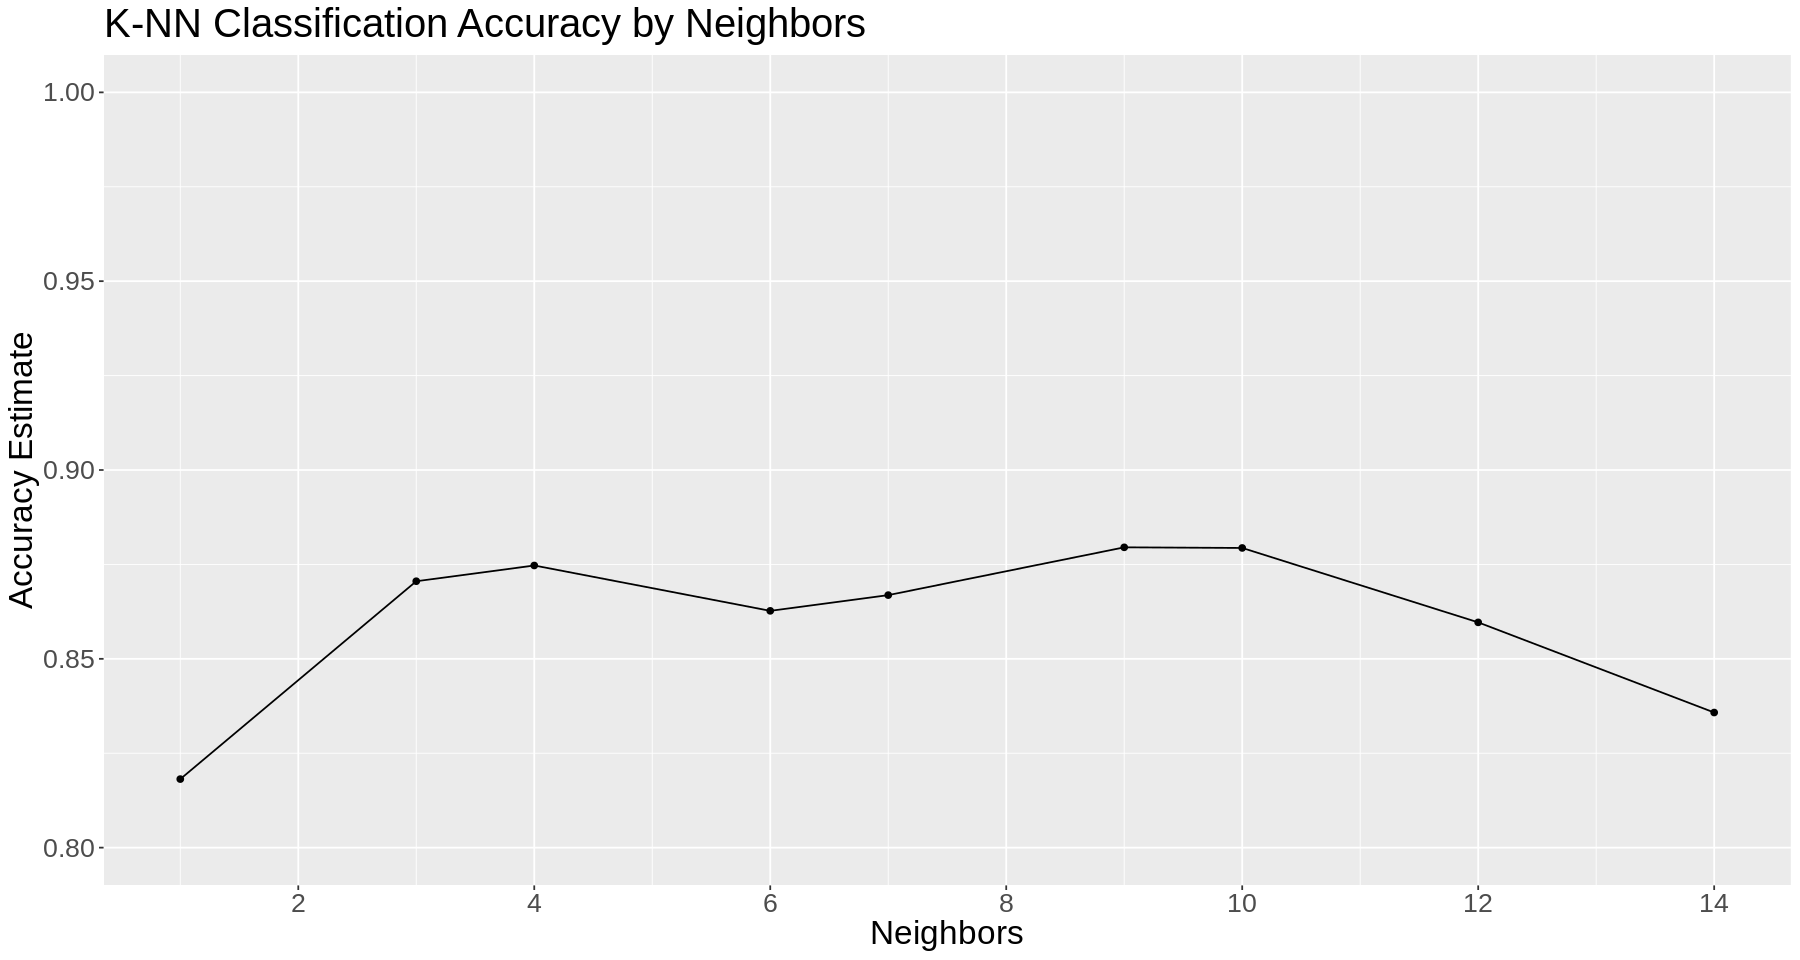

In [18]:
options(repr.plot.width=15, repr.plot.height=8)

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "K-NN Classification Accuracy by Neighbors") +
    scale_x_continuous(breaks = seq(0, 16, by = 2)) +  # adjusting the x-axis
    scale_y_continuous(limits = c(0.8, 1.0)) + # adjusting the y-axis
    theme(text = element_text(size = 20))

accuracy_versus_k

In [19]:
most_accurate_k <- knn_results %>% filter(.metric == "accuracy") %>% arrange(desc(mean)) %>% slice(1)
most_accurate_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,multiclass,0.8795256,10,0.01300364,Model6


The visualization suggests that $k=9$ averages the highest accuracy of ~88% from our 10 cross validation sets.
We edit our model specification to take $k=9$ instead of $k=3$ as follows.
After doing so, we can compare the accuracy of each model.

In [20]:
# we use the same recipe, change spec

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) %>%
    set_engine("kknn") %>%
    set_mode("classification")

unpaid_fit_tuned <- workflow() %>%
    add_recipe(unpaid_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = train_set_unpaid)

unpaid_val_predicted_tuned <- predict(unpaid_fit_tuned, val_set_unpaid) %>%
    bind_cols(val_set_unpaid)

unpaid_prediction_accuracy_tuned <- unpaid_val_predicted_tuned %>%
    metrics(truth = Type, estimate = .pred_class) %>% filter(.metric == "accuracy")

model_improvement <- unpaid_prediction_accuracy_tuned$.estimate - unpaid_prediction_accuracy$.estimate

unpaid_prediction_accuracy_tuned
print(model_improvement)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9166667


[1] 0.08333333 0.50362319


---

### 6. Analysis

#### Classifying a New Observation

In this section, we use the results of our accuracy model to predict the class of a new observation. Since our two predictors, *Total Interactions* and *Lifetime_Post_Total_Reach*, have a largely different range of values, we first centered and scaled them. 

In [79]:
new_obs_total_interactions <- 250
new_obs_total_reach <- 200

fb_recipe <- recipe(Type~ Total_Interactions + Lifetime_Post_Total_Reach, data=facebook_clean_unpaid) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors()) %>%
  prep()

scaled_fb_unpaid <- bake(fb_recipe, facebook_clean_unpaid)

scaled_fb_unpaid %>%
  dplyr::select(Total_Interactions, Lifetime_Post_Total_Reach, Type) %>%
  mutate(dist_from_new = sqrt((Total_Interactions - new_obs_total_interactions)^2 + (Lifetime_Post_Total_Reach - new_obs_total_reach)^2)) %>%
  arrange(dist_from_new) %>%
  slice(1:9)

new_obs <- tibble(Total_Interactions = 250, Lifetime_Post_Total_Reach = 200)
predict(unpaid_fit_tuned, new_obs)

Total_Interactions,Lifetime_Post_Total_Reach,Type,dist_from_new
<dbl>,<dbl>,<fct>,<dbl>
6.429315,3.473509,Photo,312.9686
6.695692,2.164463,Photo,313.5855
7.097245,1.491648,Photo,313.6994
5.713676,2.829325,Photo,313.9301
⋮,⋮,⋮,⋮
0.4934871,7.268628,Photo,315.2759
3.7655477,2.891357,Photo,315.4096
0.3265047,6.314281,Video,315.9921
4.3778166,1.071736,Photo,316.0739


.pred_class
<fct>
Photo


Since our predictors are scaled, their output values are also expressed in their scaled form. As such, the values for our 9 *k* nearest neighbours might appear different from the values  we used to predict the class of the new observation. However, the results still tell us the 9 nearest neighbours, which we can then use the to predict the class of the new observation. The results of our model predict that the new observation is a **Photo.**

#### Prediction Possibilities

In [ ]:
#A visualization for the prediction possibilities
options(repr.plot.width =14, repr.plot.height = 8) 

reach_grid <- seq(min(facebook_clean_unpaid$Lifetime_Post_Total_Reach), max(facebook_clean_unpaid$Lifetime_Post_Total_Reach), length.out = 100)
interactions_grid <- seq(min(facebook_clean_unpaid$Total_Interactions), max(facebook_clean_unpaid$Total_Interactions), length.out = 100)
asgrid <- as_tibble(expand.grid(Lifetime_Post_Total_Reach=reach_grid, Total_Interactions=interactions_grid))

knnPredGrid <- predict(unpaid_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) %>% rename(Type = .pred_class)

wkflw_plot <-
    ggplot()+
    geom_point(data = facebook_clean_unpaid, 
               mapping = aes(x = Lifetime_Post_Total_Reach/100,
               y = Total_Interactions,
               color = Type), 
               alpha=1, size=2) +
    geom_point(data = prediction_table, 
               mapping = aes(x = Lifetime_Post_Total_Reach/100,
               y = Total_Interactions,
               color = Type),
               alpha=0.09, size=6.)+
    labs(x = "Total reach (hundreds)", y = "Total interactions",
               title = "Prediction Possibilities")+
    scale_y_continuous(limits = c(0,900)) +
    scale_x_continuous(limits = c(0,1500)) +
    theme(text=element_text(size=20))

wkflw_plot

---

### 7. Model Results and Discussion

#### Results

After changing our model spec from $k$ = 3 to $k$ = 9, we see that the modifications to our model has increased our accuracy by *8.3%*, (i.e., from *83.33%* to *91.67%*) and thus we will choose the tuned model.

A possible reason the unusually high value of $k$ may lie within the validation data set. As previously discussed, the validation set was a poor holistic representation of our sample and to account for false positives, the model produced a higher critical value.

Note that throughout our procedure, we chose to use only the unpaid posts as paid posts introduce a new variable that is the amount paid for the advertisement.
This variable affects the length of time being promoted and the scope that target specific audiences and thus are more likely to interact with the post.

We also used the variables "total interactions", which is the aggregation of the variables "like", "share", and "comment", and "lifetime total reach" which refers to the number of views, as predictors to predict the type of post.
Based on our tuned model, we can predict which type of post will be successfull with an accuracy of 91.67%.

#### Discussion

Our model has showed the most accuracy with a $k$ value of 9 with an accuracy of 91.67%.
We ran in the problem of an unbalance dataset as videos, links, and status make up 54 posts out of 264 total observations.
Our model decided to acknowledge this unbalance and leave it as is for the reason that by balancing it, it drasticaly biased our model to produce a very high accuracy rate (roughly 96%).
Considering that without balancing the dataset, the accuracy rate of our model at 91.67% was good enough. 

As our research question asks which type of posts will be the most sucessful, our model first demonstrated the postive relationshinp between total impressions and total reach by type of posts which allowed to use them as our two main predictors.
Our model showed that as total reach increases total impressions (likes, shares, comments) are likely to increase as well.
Therefore, the underlying logic of our question is which type of post is likely to have the most reach, but as the type of content, such as videos or links, affects the likeliness of generetaing likes and comments which, in turns, is more likely to be picked up by Facebook's algorithm to then become viral.
Thus, it creates a positive feedback loop as viral posts, if made public, increase Facebook's placement of the post in user's newsfeed resulting in a increased reach (Quesennbury & Coolsen, 2018).
Therefore, we used both total reach and total impression to predict the success of a Facebook post.

---

### Bibliography

Moro, S., Rita, P., & Vala, B. (2016).
"Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach", 
Journal of Business Research. 69(9), 3341 - 3351. 

Quesenberry, Keith A. & Coolsen, Michael K.,"What Makes Facebook Brand Posts Engaging? A Content Analysis of Facebook Brand Post Text That Increases Shares, Likes, and Comments to Influence Organic Viral Reach", Journal of Current Issues & Research in Advertising, 40(3), 299-244.

In [78]:
facebook_clean_unpaid

Type,comment,like,share,Total_Interactions,Paid,Lifetime_Post_Total_Impressions,Lifetime_Post_Total_Reach
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
Photo,4,79,17,100,0,5091,2752
Status,5,130,29,164,0,19057,10460
Photo,0,66,14,80,0,4373,2413
Photo,19,325,49,393,0,13594,7244
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Photo,5,53,26,84,0,7536,4684
Photo,0,53,22,75,0,6229,3480
Photo,4,93,18,115,0,7216,3778
Photo,7,91,38,136,0,7564,4156
